# Digit Recognizer

## 프로젝트를 통해 알게된 사실
* np.random.seed() : 랜덤성 제어
* import itertools : 효율적인 루핑을 위한 이터레이터 만드는 함수
* from keras.optimizers import RMSprop  ->  from tensorflow.keras.optimizers import RMSprop
* sns.set() : seaborn 테마 설정
* more the pooling dimension is high, more the downsampling is important.
* dropout은 일반화를 개선하고 과적합을 줄인다.
* Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
* ZCA whitening :sero-phase component analysis를 의미. ZCA를 적용하면 입력데이터의 n차원을 유지하며 차원감소는 일어나지 않는다.

## Dataset

https://www.kaggle.com/competitions/digit-recognizer/data

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2) # 랜덤성 제어

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools # 효율적인 루핑을 위한 이터레이터 만드는 함수

from keras.utils.np_utils import to_categorical # 원핫인코딩 변환
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style="white", context="notebook", palette="deep") #seaborn 테마 설정


## Data preparation

### Load data

In [2]:
# 압축풀기
# !unzip digit-recognizer.zip

In [3]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape, test.shape

((42000, 785), (28000, 784))

In [4]:
# Confirm target
set(train.columns) - set(test.columns)

{'label'}

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

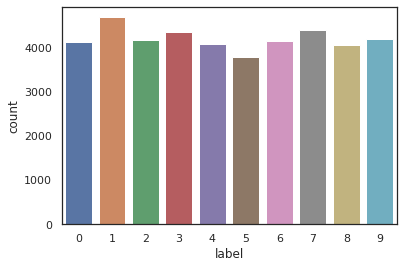

In [5]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels=["label"], axis=1)

# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

* 각 숫자는 비슷한 분포를 띄고 있음

### Check for null and missing values

In [6]:
# Check missing
X_train.isnull().sum().sum()

0

In [7]:
test.isnull().sum().sum()

0

### Normalization

In [8]:
# Normalize the data
X_train = X_train/255
test = test/255

### Reshape

In [9]:
# Reshape image in 3 dimensions (height=28px, width=28px, channel=1)
# mnist 이미지는 회색으로 하니까 channel 1로
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### Label encoding

In [10]:
# one-hot encoding
Y_train = to_categorical(Y_train, num_classes=10)

### Split training and validation set

In [11]:
# Set the random seed
random_seed = 2

In [12]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=0.1,
                                                  random_state=random_seed)

* train 데이터가 비교적 균일한 데이터이므로 무작위 분할을 했을 때 과대적합 되지 않습니다. 만약 균일하지 않은 데이터는 stratify 옵션을 활용하여 층화추출을 해줘야합니다.

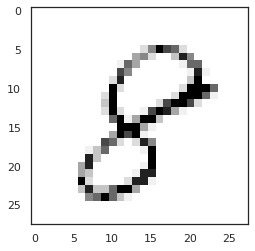

In [15]:
# Some examples
g = plt.imshow(X_train[0][:,:,0], cmap="Greys")

* 나는 왜 cmap="Greys" 따로 설정해줘야 회색으로 바뀌지..?

## CNN

### Define the model

In [18]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2\
# -> Flatten ->Dense-> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding="Same",
                 activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding="Same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same",
                 activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))


### Set the optimizer and annealer

In [19]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0)

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
# Compile the model
model.compile(optimizer = optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [30]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy",
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [31]:
epochs = 30
batch_size=86

### Data augmentation

* 여기서는 데이터증강기법을 사용하여 정확도를 98.114% -> 99.67% 로 늘림

In [32]:
# Without data augmentation i obtained an accuracy of 0.98114

# history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
#            validation_date=(X_val, Y_val), verbose=2)

In [33]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=10, # randomly rotate images in the range (degrees, 0~180)
        zoom_range=0.1, # Randomly zoom image
        width_shift_range=0.1, # 이미지를 수평하게 랜덤으로 이동 (전체 너비의 크기)
        height_shift_range=0.1, # 이미지를 세로로 랜덤으로 이동 (전체 너비의 크기)
        horizontal_flip=False, # 랜덤하게 이미지 뒤집기
        vertical_flip=False) # 랜덤하게 이미지 뒤집기

datagen.fit(X_train)

* 이미지를 
1. 10도씩 임의로 회전
2. 10% 확대
3. 너비와 세로 각각 10%씩 임의로 이동
4. 6과 9와 같은 대칭적인 숫자가 있기 때문에 뒤집기는 적용하지 않음

In [35]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
439/439 - 7s - loss: 0.0647 - accuracy: 0.9826 - val_loss: 0.0223 - val_accuracy: 0.9940 - lr: 0.0010 - 7s/epoch - 16ms/step
Epoch 2/30
439/439 - 7s - loss: 0.0640 - accuracy: 0.9830 - val_loss: 0.0375 - val_accuracy: 0.9938 - lr: 0.0010 - 7s/epoch - 16ms/step
Epoch 3/30
439/439 - 7s - loss: 0.0697 - accuracy: 0.9830 - val_loss: 0.0277 - val_accuracy: 0.9926 - lr: 0.0010 - 7s/epoch - 17ms/step
Epoch 4/30

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
439/439 - 7s - loss: 0.0706 - accuracy: 0.9821 - val_loss: 0.0219 - val_accuracy: 0.9938 - lr: 0.0010 - 7s/epoch - 17ms/step
Epoch 5/30
439/439 - 7s - loss: 0.0492 - accuracy: 0.9872 - val_loss: 0.0205 - val_accuracy: 0.9943 - lr: 5.0000e-04 - 7s/epoch - 17ms/step
Epoch 6/30
439/439 - 7s - loss: 0.0503 - accuracy: 0.9866 - val_loss: 0.0261 - val_accuracy: 0.9945 - lr: 5.0000e-04 - 7s/epoch - 16ms/step
Epoch 7/30
439/439 - 7s - loss: 0.0491 - accuracy: 0.9868 - val_loss: 0.0372 - val_accuracy: 0.

## Evaluate the model

### Traing and validation curves

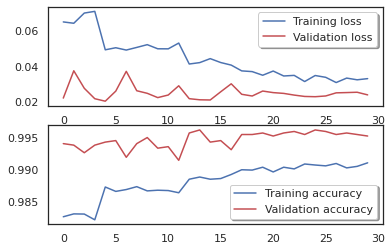

In [37]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

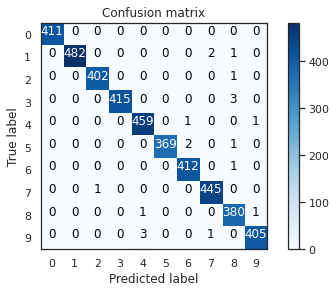

In [40]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

* 9를 4로 예측한값이 3개 있습니다.

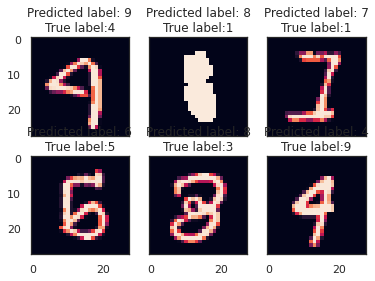

In [42]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true !=0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """
    This function shows 6 images with their predicted and real labels
    """
    n=0
    nrows=2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28,28)))
            ax[row, col].set_title("Predicted label: {}\nTrue label:{}".format(pred_errors[error], obs_errors[error]))
            n+=1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilites of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, 
               Y_pred_classes_errors, Y_true_errors)

In [43]:
# # predict results
# results = model.predict(test)

# # select the index with the maximum probability
# results = np.argmax(results, axis=1)

# results=pd.Series(results, name="label")

In [44]:
# submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

# submission.to_csv("cnn_mnist_datagen.csv",index=False)

439/439 - 7s - loss: 0.0421 - accuracy: 0.9888 - val_loss: 0.0213 - val_accuracy: 0.9962 - lr: 2.5000e-04 - 7s/epoch - 17ms/step